In [3]:
using Pkg
using DotEnv
include("src/test_name.jl")
using .Test_name

┌ Warning: Replacing docs for `Main.Test_name.Download.Metadata.to_rcm_time :: Tuple{String}` in module `Main.Test_name.Download.Metadata`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Main.Test_name.Download.Metadata.get_bbox :: Tuple{Any}` in module `Main.Test_name.Download.Metadata`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Main.Test_name.Download.Metadata.bounding_box_to_geojson :: Tuple{}` in module `Main.Test_name.Download.Metadata`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Main.Test_name.Download.Metadata.coordinate_to_geojson :: Union{Tuple{T}, Tuple{T, T}} where T<:Real` in module `Main.Test_name.Download.Metadata`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Main.Test_name.Download.Metadata.wkt_to_tuples :: Tuple{Any}` in module `Main.Test_name.Download.Metadata`
└ @ Base.Docs docs/Docs.jl:243


In [149]:
using DSP  # Digital Signal Processing for convolution

function estimate_noise_level(array::Matrix{Float64}, kernel::Matrix{Float64})
    # Perform convolution
    conv_result = conv(array, kernel)

    # Calculate the start and end indices to trim the convolved result
    vertical_trim = div(size(kernel, 1) - 1, 2)
    horizontal_trim = div(size(kernel, 2) - 1, 2)

    # Trim the convolved result to match the input array size
    trimmed_result = conv_result[vertical_trim+1:end-vertical_trim, horizontal_trim+1:end-horizontal_trim]

    # Normalize the convolution result
    norm_factor = sum(kernel) - kernel[div(end, 2) + 1, div(end, 2) + 1]
    return trimmed_result / norm_factor
end


function create_cfar_kernel(bg_win_size, guard_win_size)
    # Create a kernel with ones
    kernel = ones(bg_win_size)

    # Set the guard cells and the cell under test to zero
    kernel_center = div.(bg_win_size, 2) .+ 1
    kernel[kernel_center[1]-guard_win_size:kernel_center[1]+guard_win_size, kernel_center[2]-guard_win_size:kernel_center[2]+guard_win_size] .= 0
    return kernel
end

function ca_cfar_detector(array::Matrix{Float64}, bg_win_size, guard_win_size, test_win_size, pfa)
    # Create the kernel for noise estimation
    kernel = create_cfar_kernel(bg_win_size, guard_win_size)

    # Estimate noise level using convolution
    noise_level = estimate_noise_level(array, kernel)

    # Calculate the threshold
    # SAR images often have a multiplicative noise model, hence using log-scale
    norm_factor = sum(kernel) - kernel[div(end, 2) + 1, div(end, 2) + 1]
    #threshold = exp(log(noise_level) + sqrt(2*log(1/pfa)) / norm_factor)
    threshold = exp.(log.(noise_level) .+ (sqrt(2*log(1/pfa)) / norm_factor))

    # Detection: 1 for object, 0 for no object
    detection_array = array .> threshold

    return detection_array
end


ca_cfar_detector (generic function with 2 methods)

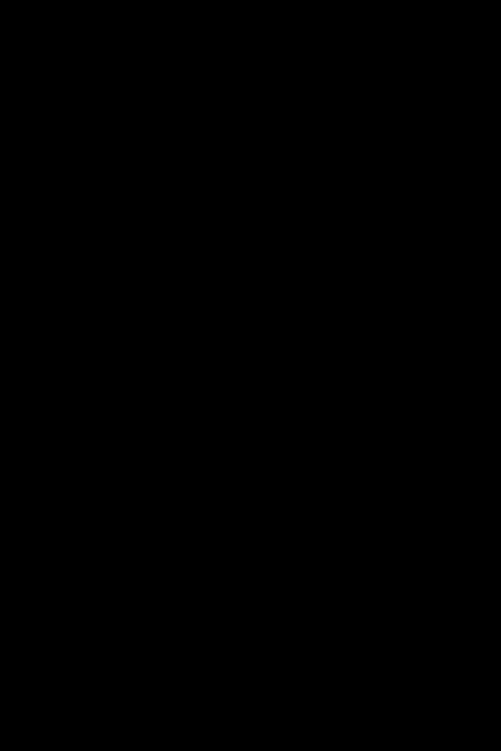

In [182]:

# CA-CFAR parameters
bg_win_size = (35, 35)
guard_win_size = 7
test_win_size = 3
pfa = 1e-308 # Probability of false alarm

object = ca_cfar_detector(test_img.data[1][1000:4000,3000:5000], bg_win_size, guard_win_size, test_win_size, pfa)  
Images.Gray.(Int.(object))
# Dete

SAR-Specific Considerations:
SAR data often exhibits a multiplicative noise model. Therefore, in this implementation, the threshold is computed in a logarithmic scale using exp(log(noise_level) + sqrt(2*log(1/pfa)) / norm_factor).
The choice of the background window size (bg_win_size), guard window size (guard_win_size), and test window size (test_win_size) is crucial for effective detection in SAR images. These parameters should be tuned based on the spatial resolution and noise characteristics of the SAR data.
SAR imagery often contains speckle noise, which might affect the detection performance. Pre-processing steps such as speckle filtering may be necessary before applying the CA-CFAR algorithm.
Validation with actual SAR data is essential to ensure the algorithm performs as expected in real-world scenarios.
Remember that this is a template and may need further tuning or modification based on the specific requirements and characteristics of your SAR data.

In [16]:
safe_folder = "/Users/kaaso/Documents/coding/JuliaEO2024/data/S1A_IW_GRDH_1SDV_20220612T173329_20220612T173354_043633_05359A_EA25.SAFE";

In [17]:
test_img = Test_name.Sensors.Sentinel1.Sentinel1GRD(safe_folder);

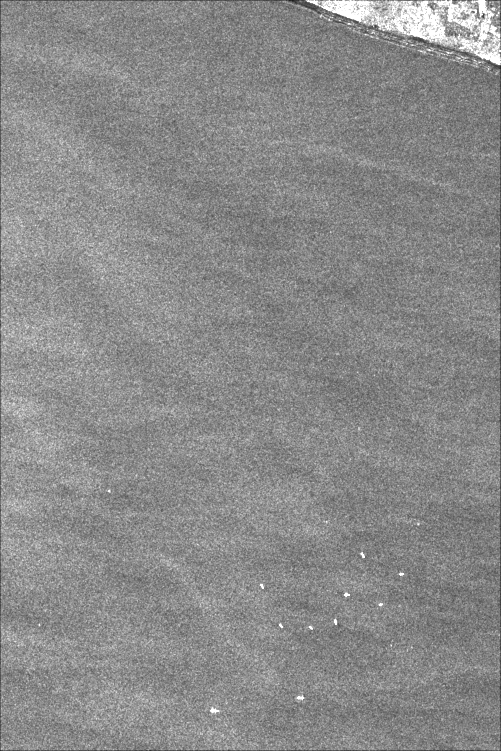

In [27]:
Test_name.Visualize.sar2gray(test_img.data[1][1000:4000,3000:5000],p_quantile=0.99)

In [123]:
using DSP  # Digital Signal Processing for convolution

function estimate_noise_level(array::Matrix{Float64}, kernel::Matrix{Float64})
    # Perform convolution
    conv_result = conv(array, kernel)

    # Calculate the start and end indices to trim the convolved result
    vertical_trim = div(size(kernel, 1) - 1, 2)
    horizontal_trim = div(size(kernel, 2) - 1, 2)

    # Trim the convolved result to match the input array size
    noise_level = conv_result[vertical_trim+1:end-vertical_trim, horizontal_trim+1:end-horizontal_trim]
    norm_factor = sum(kernel) - kernel[div(end, 2) + 1, div(end, 2) + 1]
    return noise_level / norm_factor
end

function create_cfar_kernel(bg_win_size, guard_win_size)
    kernel = ones(bg_win_size)
    kernel_center = div.(bg_win_size, 2) .+ 1
    kernel[kernel_center[1]-guard_win_size:kernel_center[1]+guard_win_size, kernel_center[2]-guard_win_size:kernel_center[2]+guard_win_size] .= 0
    return kernel
end

function ca_cfar_detector(array::Matrix{Float64}, bg_win_size, guard_win_size, test_win_size, pfa)
    # Create the kernel for noise estimation
    kernel = create_cfar_kernel(bg_win_size, guard_win_size)

    # Estimate noise level using convolution
    noise_level = estimate_noise_level(array, kernel)

    # Calculate threshold
    norm_factor = sum(kernel) - kernel[div(end, 2) + 1, div(end, 2) + 1]
    threshold = noise_level .* (pfa ^ (-1 / norm_factor) - 1)

    # Detection (1 for object, 0 for no object)
    detection_array = array .> threshold

    return detection_array
end


ca_cfar_detector (generic function with 2 methods)

In [80]:
# CA-CFAR parameters
bg_win_size = (31, 31)
guard_win_size = 14
test_win_size = 3
pfa = 1e-6  # Probability of false alarm

1.0e-6

In [81]:
object = ca_cfar_detector(test_img.data[1][1000:4000,3000:5000], bg_win_size, guard_win_size, test_win_size, pfa);
println(minimum(Int.(object)))
println(maximum(Int.(object)))

0
1


In [84]:
object

3001×2001 BitMatrix:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 ⋮              ⋮              ⋮        ⋱     ⋮              ⋮              ⋮
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     

In [57]:
using Images

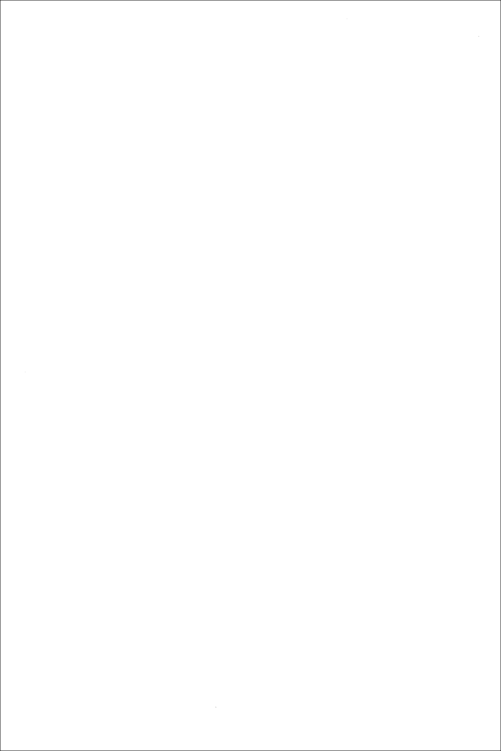

In [82]:
Images.Gray.(Int.(object))

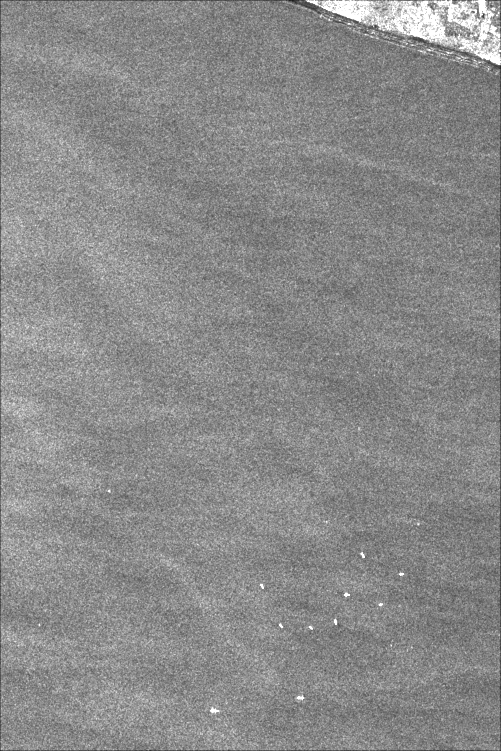

In [35]:
Test_name.Visualize.sar2gray(test_img.data[1][1000:4000,3000:5000],p_quantile=0.99)